# Elevation - Digital Terrain Model of Plovdiv

In [2]:
import rasterio as rio
import os
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

In [14]:
demplovdiv = rio.open(r"C:\Users\User\Documents\UNITN\Geospatial\raster\plovdiv\ASTGTMV003_N42E024_dem.tif")

In [3]:
demplovdiv.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.000277777777777778, 0.0, 23.9998611111111,
       0.0, -0.000277777777777778, 43.0001388888889), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

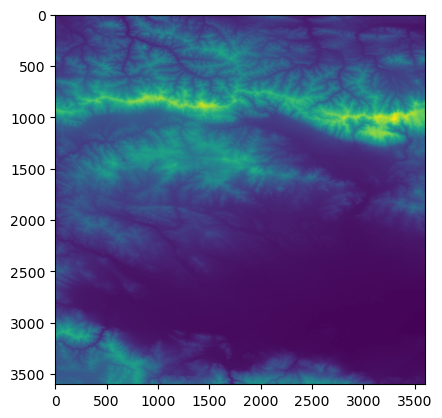

In [5]:
show(demplovdiv.read(1))

Profile of altitude

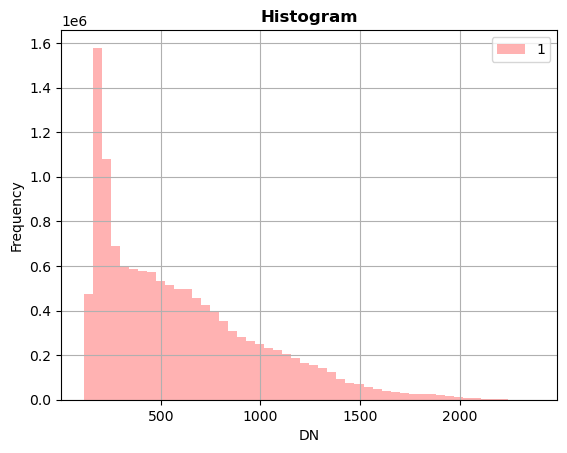

In [5]:
rio.plot.show_hist(demplovdiv, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

Contour lines

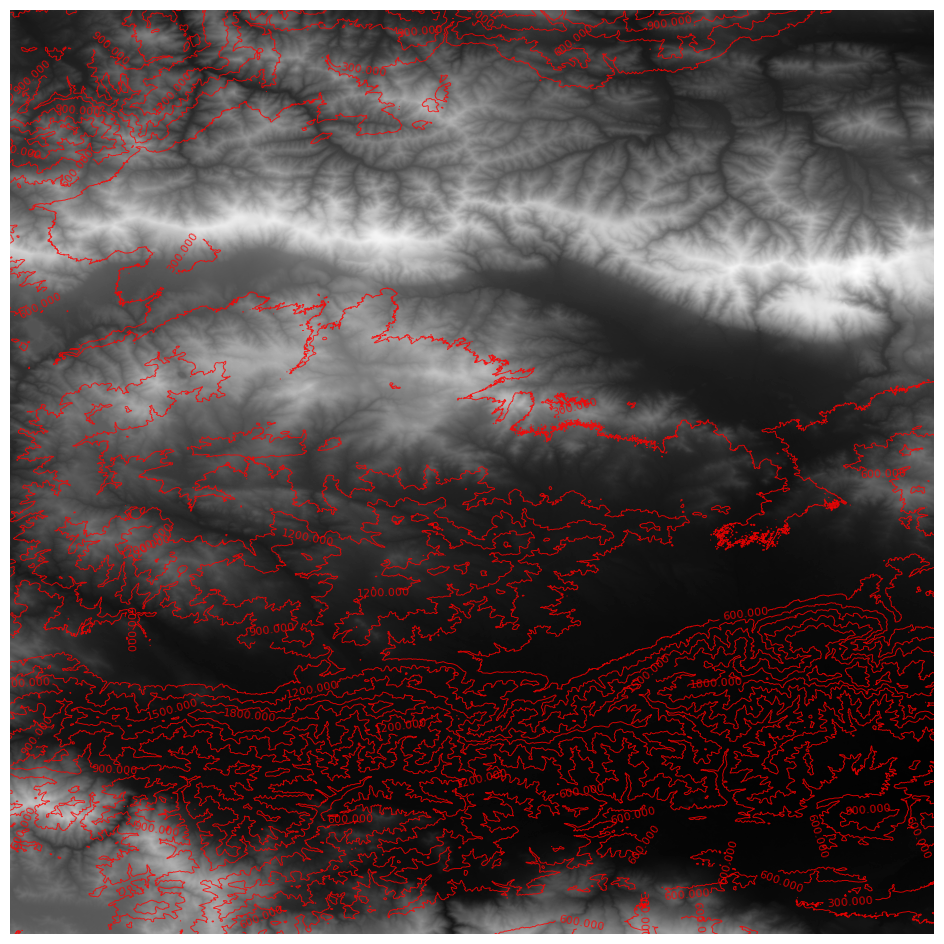

In [6]:
dem_array = demplovdiv.read(1).astype('float64')
fig, ax = plt.subplots(1, figsize=(12, 12))
show(dem_array, cmap='Greys_r', ax=ax)
show(dem_array, contour=True, ax=ax, linewidths=0.7)
plt.axis("off")
plt.show()

Read Plovdiv

In [10]:
municipalities = gpd.read_file("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\municipalities.geojson")
municipalities.crs #4326
municipalities.tail()

,nuts4,nuts3,geometry
260,PDV22,PDV,"POLYGON ((24.76400 42.19200, 24.77800 42.17600..."
261,DOB28,DOB,"POLYGON ((27.88400 43.61300, 27.88400 43.58300..."
262,SFO57,SFO,"POLYGON ((24.10100 42.65800, 24.10000 42.65600..."
263,SFO58,SFO,"POLYGON ((24.07600 42.75100, 24.10500 42.71600..."
264,JAM26,JAM,"POLYGON ((26.53200 42.54800, 26.52300 42.51000..."


In [11]:
plovdiv_city = municipalities[municipalities.nuts4 == "PDV22"]
plovdiv = municipalities[municipalities.nuts3 == "PDV"]

In [ ]:
plovdiv_city.explore()

Plot the Polygons on top of the DEM

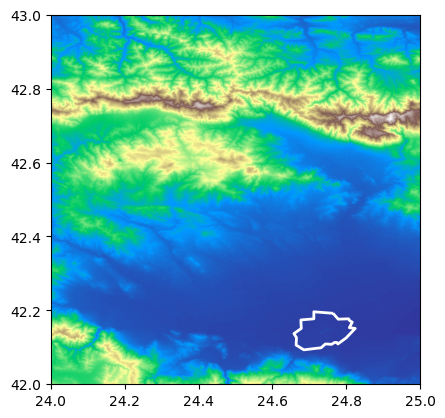

In [5]:
ax = plovdiv_city.plot(facecolor='None', edgecolor='white', linewidth=2)
show((demplovdiv, 1), ax=ax, cmap = "terrain")

In [36]:
demplovdiv.crs.to_wkt()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [37]:
municipalities.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Clip Plovdiv Only

In [12]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

coords = getFeatures(plovdiv_city)


In [15]:
raster_plovdiv, raster_plovdiv_transform = mask(demplovdiv, coords, crop = True)

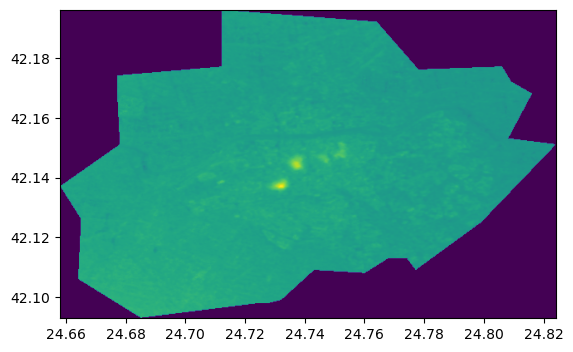

In [61]:
show(raster_plovdiv, transform = raster_plovdiv_transform)

In [21]:
raster_plovdiv.shape

(1, 372, 598)

In [16]:
demplovdiv.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 3601,
 'height': 3601,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.000277777777777778, 0.0, 23.9998611111111,
        0.0, -0.000277777777777778, 43.0001388888889)}

In [17]:
demplovdiv.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.000277777777777778, 0.0, 23.9998611111111,
       0.0, -0.000277777777777778, 43.0001388888889), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [24]:
meta = demplovdiv.meta

meta.update(
       width = raster_plovdiv.shape[2],
       height = raster_plovdiv.shape[1],
       transform = raster_plovdiv_transform)

with rasterio.open(r'C:\Users\User\Documents\UNITN\Geospatial\raster\dems\dem_plovdiv_clip2.tiff', 'w', **meta) as dst:
        dst.write(raster_plovdiv)

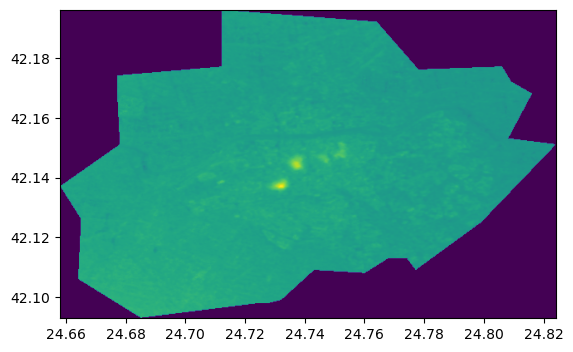

In [26]:
p = rasterio.open(r"C:\Users\User\Documents\UNITN\Geospatial\raster\dems\dem_plovdiv_clip2.tiff")
show(p, transform=raster_plovdiv_transform)

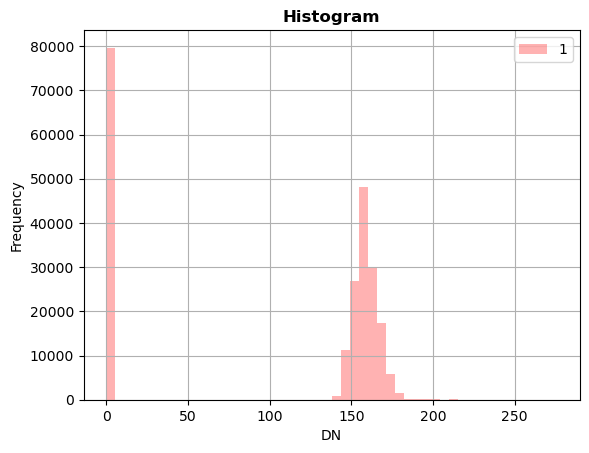

In [63]:
rio.plot.show_hist(p, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

In [30]:
p_data = p.read(1)
print(p_data.max())
print(p_data[p_data != 0].min())
print(p_data.mean())

276
130
102.17678552163125


This would imply the maximum height of the Dzhendem tepe, which is the highest of the Plovdiv's hills (https://www.visitplovdiv.com/en/node/697)

In [91]:
import pandas as pd

In [55]:
indices = np.where(p_data == np.nanmax(p_data))
p_data[indices[0][0], indices[1][0]]
pointmax = p.xy(indices[0][0], indices[1][0])
df = pd.DataFrame({"Latitude": pointmax[1], "Longitude": pointmax[0]}, index = [0])
pointmax = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs = p.crs)

In [57]:
indices2 = np.where(p_data == np.nanmin(p_data))
p_data[indices2[0][0], indices2[1][0]]
pointmin = p.xy(indices2[0][0], indices2[1][0])
df = pd.DataFrame({"Latitude": pointmin[1], "Longitude": pointmin[0]}, index = [0])
pointmin = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs = p.crs)


In [90]:
pointmax

,Latitude,Longitude,geometry
0,42.136944,24.731667,POINT (24.73167 42.13694)


In [58]:
pointmin

,Latitude,Longitude,geometry
0,42.143611,24.686111,POINT (24.68611 42.14361)


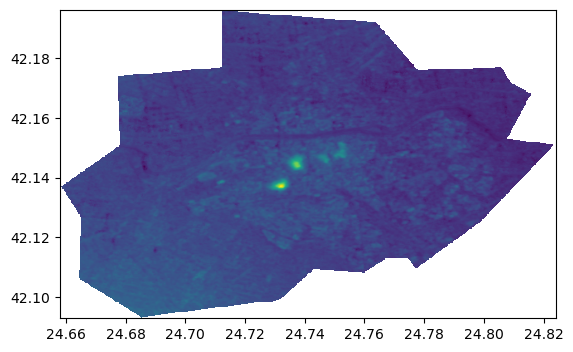

In [52]:
p_data = p_data.astype("float")
p_data[p_data == 0] = np.nan
show(p_data, transform = raster_plovdiv_transform)

So the highest point is really the top of this hill.

In [56]:
pointmax.explore()

In [59]:
pointmin.explore()

In [68]:
pointmax

,Latitude,Longitude,geometry
0,42.136944,24.731667,POINT (24.73167 42.13694)


In [69]:
pointmin

,Latitude,Longitude,geometry
0,42.143611,24.686111,POINT (24.68611 42.14361)


## Hillshade

In [23]:
import contextily as cx

In [33]:
import xarray as xr
import numpy as np

from xrspatial import hillshade
from xrspatial import viewshed

In [34]:
raster = xr.open_rasterio(r"C:\Users\User\Documents\UNITN\Geospatial\raster\dems\dem_plovdiv_clip.tiff").sel(band=1).drop('band', dim=None)
raster.name = 'elevation'
illuminated = hillshade(raster, name='Hillshade')

C:\Users\User\AppData\Local\Temp\ipykernel_19508\429716986.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  raster = xr.open_rasterio(r"C:\Users\User\Documents\UNITN\Geospatial\raster\dems\dem_plovdiv_clip.tiff").sel(band=1).drop('band', dim=None)


In [ ]:
raster = xr.open_rasterio(r"C:\Users\User\Documents\UNITN\Geospatial\raster\dems\dem_plovdiv_clip.tiff").sel(band=1).drop('band', dim=None)
raster.name = 'elevation'
illuminated = hillshade(raster, name='Hillshade')

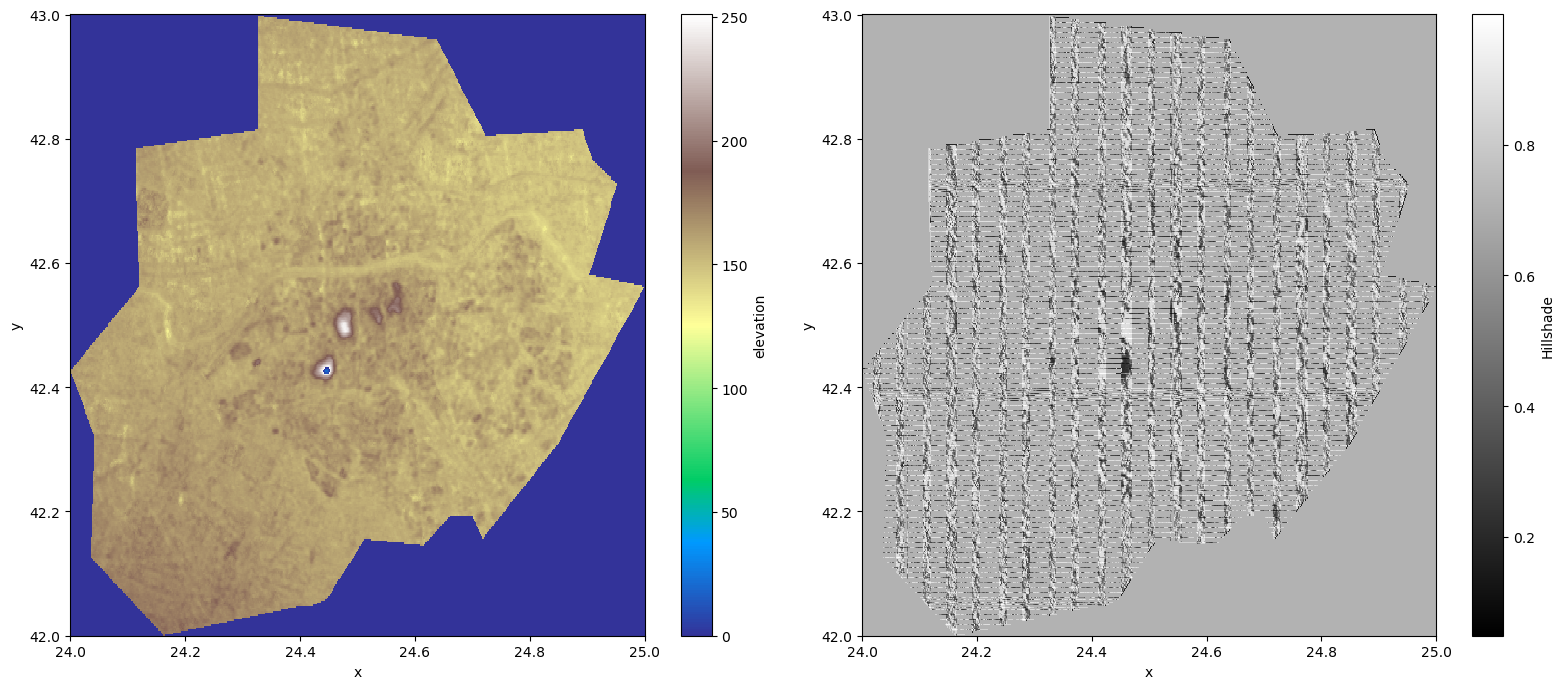

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 7))
raster.plot.imshow(ax=ax1, cmap='terrain')
illuminated.plot.imshow(ax=ax2, cmap='gray')
plt.tight_layout()

# Appendix

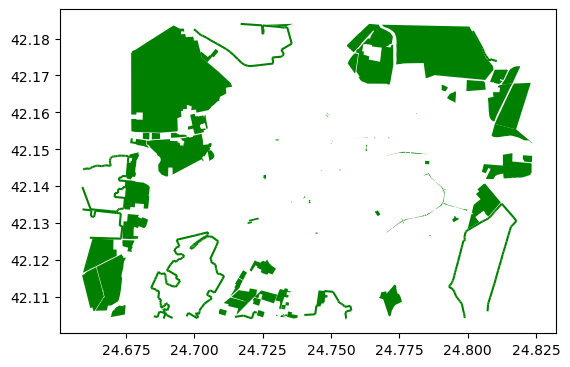

In [73]:
landuse = gpd.read_file(r"C:\Users\User\Documents\UNITN\Geospatial\raster\green_landuse.geojson")
landuse.plot(color = 'green')

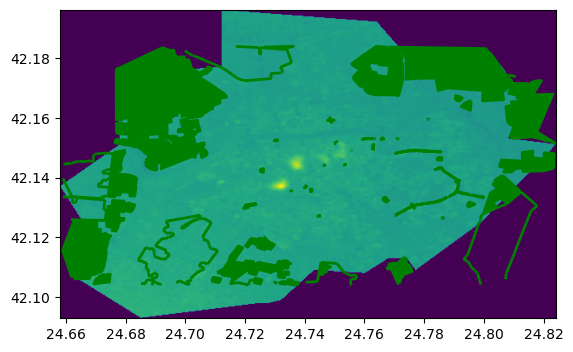

In [85]:
ax = landuse.plot(facecolor='green', edgecolor='green', linewidth=2)
show(p, ax = ax)